# Glucose Model Analysis - Machine Learning Approach

This notebook performs feature engineering and machine learning analysis on glucose response data.

## Setup and Imports

In [1]:
# Setup and imports

import sys
import os
from pathlib import Path

# Get the project root (one level up from notebooks directory)
project_root = Path.cwd().parent
print(f"Project root: {project_root}")

# Add project root to Python path
sys.path.append(str(project_root))

# Change working directory to project root
os.chdir(project_root)
print(f"Changed working directory to: {os.getcwd()}")

# Verify the data file exists now
data_file = Path("data/raw/hall2018.csv")
print(f"Data file exists: {data_file.exists()}")
print(f"Looking for file at: {data_file.absolute()}")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.features.feature_engineering import EnhancedFeatureEngineer
from src.models.xgboost_regressor import GlucoseXGBoostRegressor, MultiLinearRegressor
from src.visualization.plotting import GlucosePlotter

Project root: /Users/philipp.dubach/Projects/glucose-response-analysis
Changed working directory to: /Users/philipp.dubach/Projects/glucose-response-analysis
Data file exists: True
Looking for file at: /Users/philipp.dubach/Projects/glucose-response-analysis/data/raw/hall2018.csv


## Feature Engineering

In [7]:
feature_engineer = EnhancedFeatureEngineer()

# Load fitted parameters (from previous notebook)
df_fitted_params = pd.read_csv(os.getcwd()+"/results/fitted_parameters.csv")

# Create comprehensive ML dataset
df_ml = feature_engineer.prepare_complete_ml_dataset(df_fitted_params)

print(f"ML dataset shape: {df_ml.shape}")
print(f"Features: {df_ml.columns.tolist()}")

ML dataset shape: (112, 80)
Features: ['A', 'delta', 'sigma', 'baseline', 'r_squared', 'userID', 'meal', 'time', 'CHO', 'PRO', 'FAT', 'Meal', 'hour', 'day_of_week', 'month', 'is_weekend', 'is_breakfast', 'is_lunch', 'is_dinner', 'is_snack', 'age', 'gender', 'BMI', 'height', 'weight', 'bmi_underweight', 'bmi_normal', 'bmi_overweight', 'bmi_obese', 'total_calories', 'cho_pct', 'pro_pct', 'fat_pct', 'cho_pro_ratio', 'cho_fat_ratio', 'pro_fat_ratio', 'cgm_24h_mean', 'cgm_24h_std', 'cgm_24h_TIR', 'cgm_24h_IQR', 'cgm_24h_below_70_pct', 'cgm_24h_above_140_pct', 'cgm_24h_skewness', 'cgm_24h_kurtosis', 'cgm_4h_mean', 'cgm_4h_std', 'cgm_4h_TIR', 'cgm_4h_IQR', 'cgm_4h_below_70_pct', 'cgm_4h_above_140_pct', 'cgm_4h_skewness', 'cgm_4h_kurtosis', 'GRT1_24h_pct', 'GRT2_24h_pct', 'GRT3_24h_pct', 'GRT1_4h_pct', 'GRT2_4h_pct', 'GRT3_4h_pct', 'autocorr_8h', 'autocorr_4h', 'autocorr_1h', 'autocorr_40min', 'autocorr_20min', 'autocorr_10min', 'user_A_mean', 'user_A_std', 'user_A_min', 'user_A_max', 'user_de

## Feature Analysis

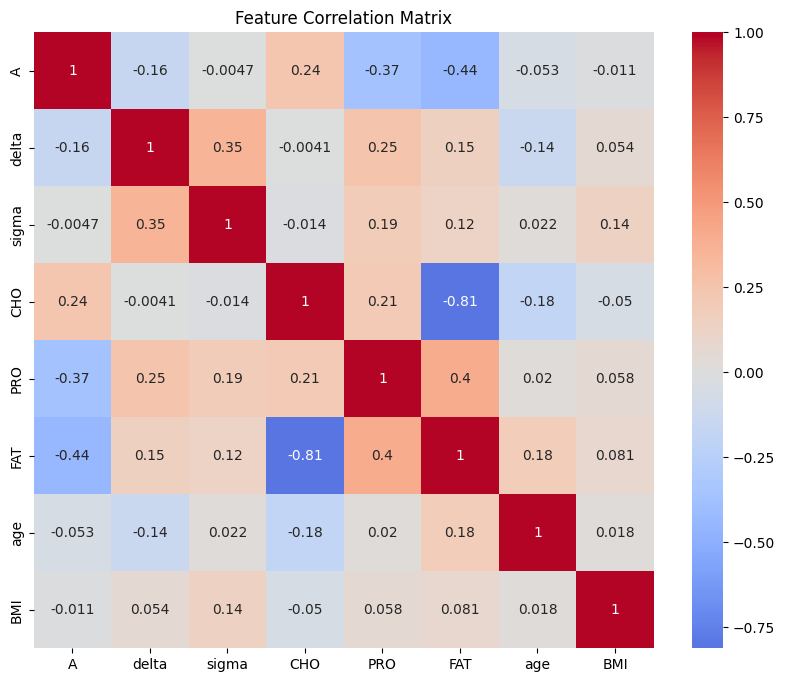

In [8]:
# Correlation matrix for key features
key_features = ['A', 'delta', 'sigma', 'CHO', 'PRO', 'FAT', 'age', 'BMI']
available_features = [f for f in key_features if f in df_ml.columns]

if len(available_features) > 1:
    plt.figure(figsize=(10, 8))
    correlation_matrix = df_ml[available_features].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')
    plt.show()

## XGBoost Model Training

In [9]:
xgboost_regressor = GlucoseXGBoostRegressor()

# Train models for all targets
model_results = xgboost_regressor.train_all_targets(df_ml, hyperparameter_tuning=False)

# Display results
for target_name, results in model_results.items():
    print(f"\n{target_name.upper()} Results:")
    print(f"Train R²: {results['train_metrics']['r_squared']:.3f}")
    print(f"Test R²: {results['test_metrics']['r_squared']:.3f}")
    print(f"Test RMSE: {results['test_metrics']['rmse']:.3f}")
    print(f"Test MAE: {results['test_metrics']['mae']:.3f}")
    print(f"Correlation: {results['test_metrics']['correlation']:.3f} "
          f"(p={results['test_metrics']['p_value']:.4f})")


AMPLITUDE Results:
Train R²: 0.952
Test R²: 0.352
Test RMSE: 17.217
Test MAE: 13.029
Correlation: 0.660 (p=0.0006)

TIME_TO_PEAK Results:
Train R²: 0.931
Test R²: -0.358
Test RMSE: 25.159
Test MAE: 22.367
Correlation: -0.056 (p=0.7986)

CURVE_WIDTH Results:
Train R²: 0.912
Test R²: -0.275
Test RMSE: 16.150
Test MAE: 12.188
Correlation: -0.113 (p=0.6083)


## Model Visualization

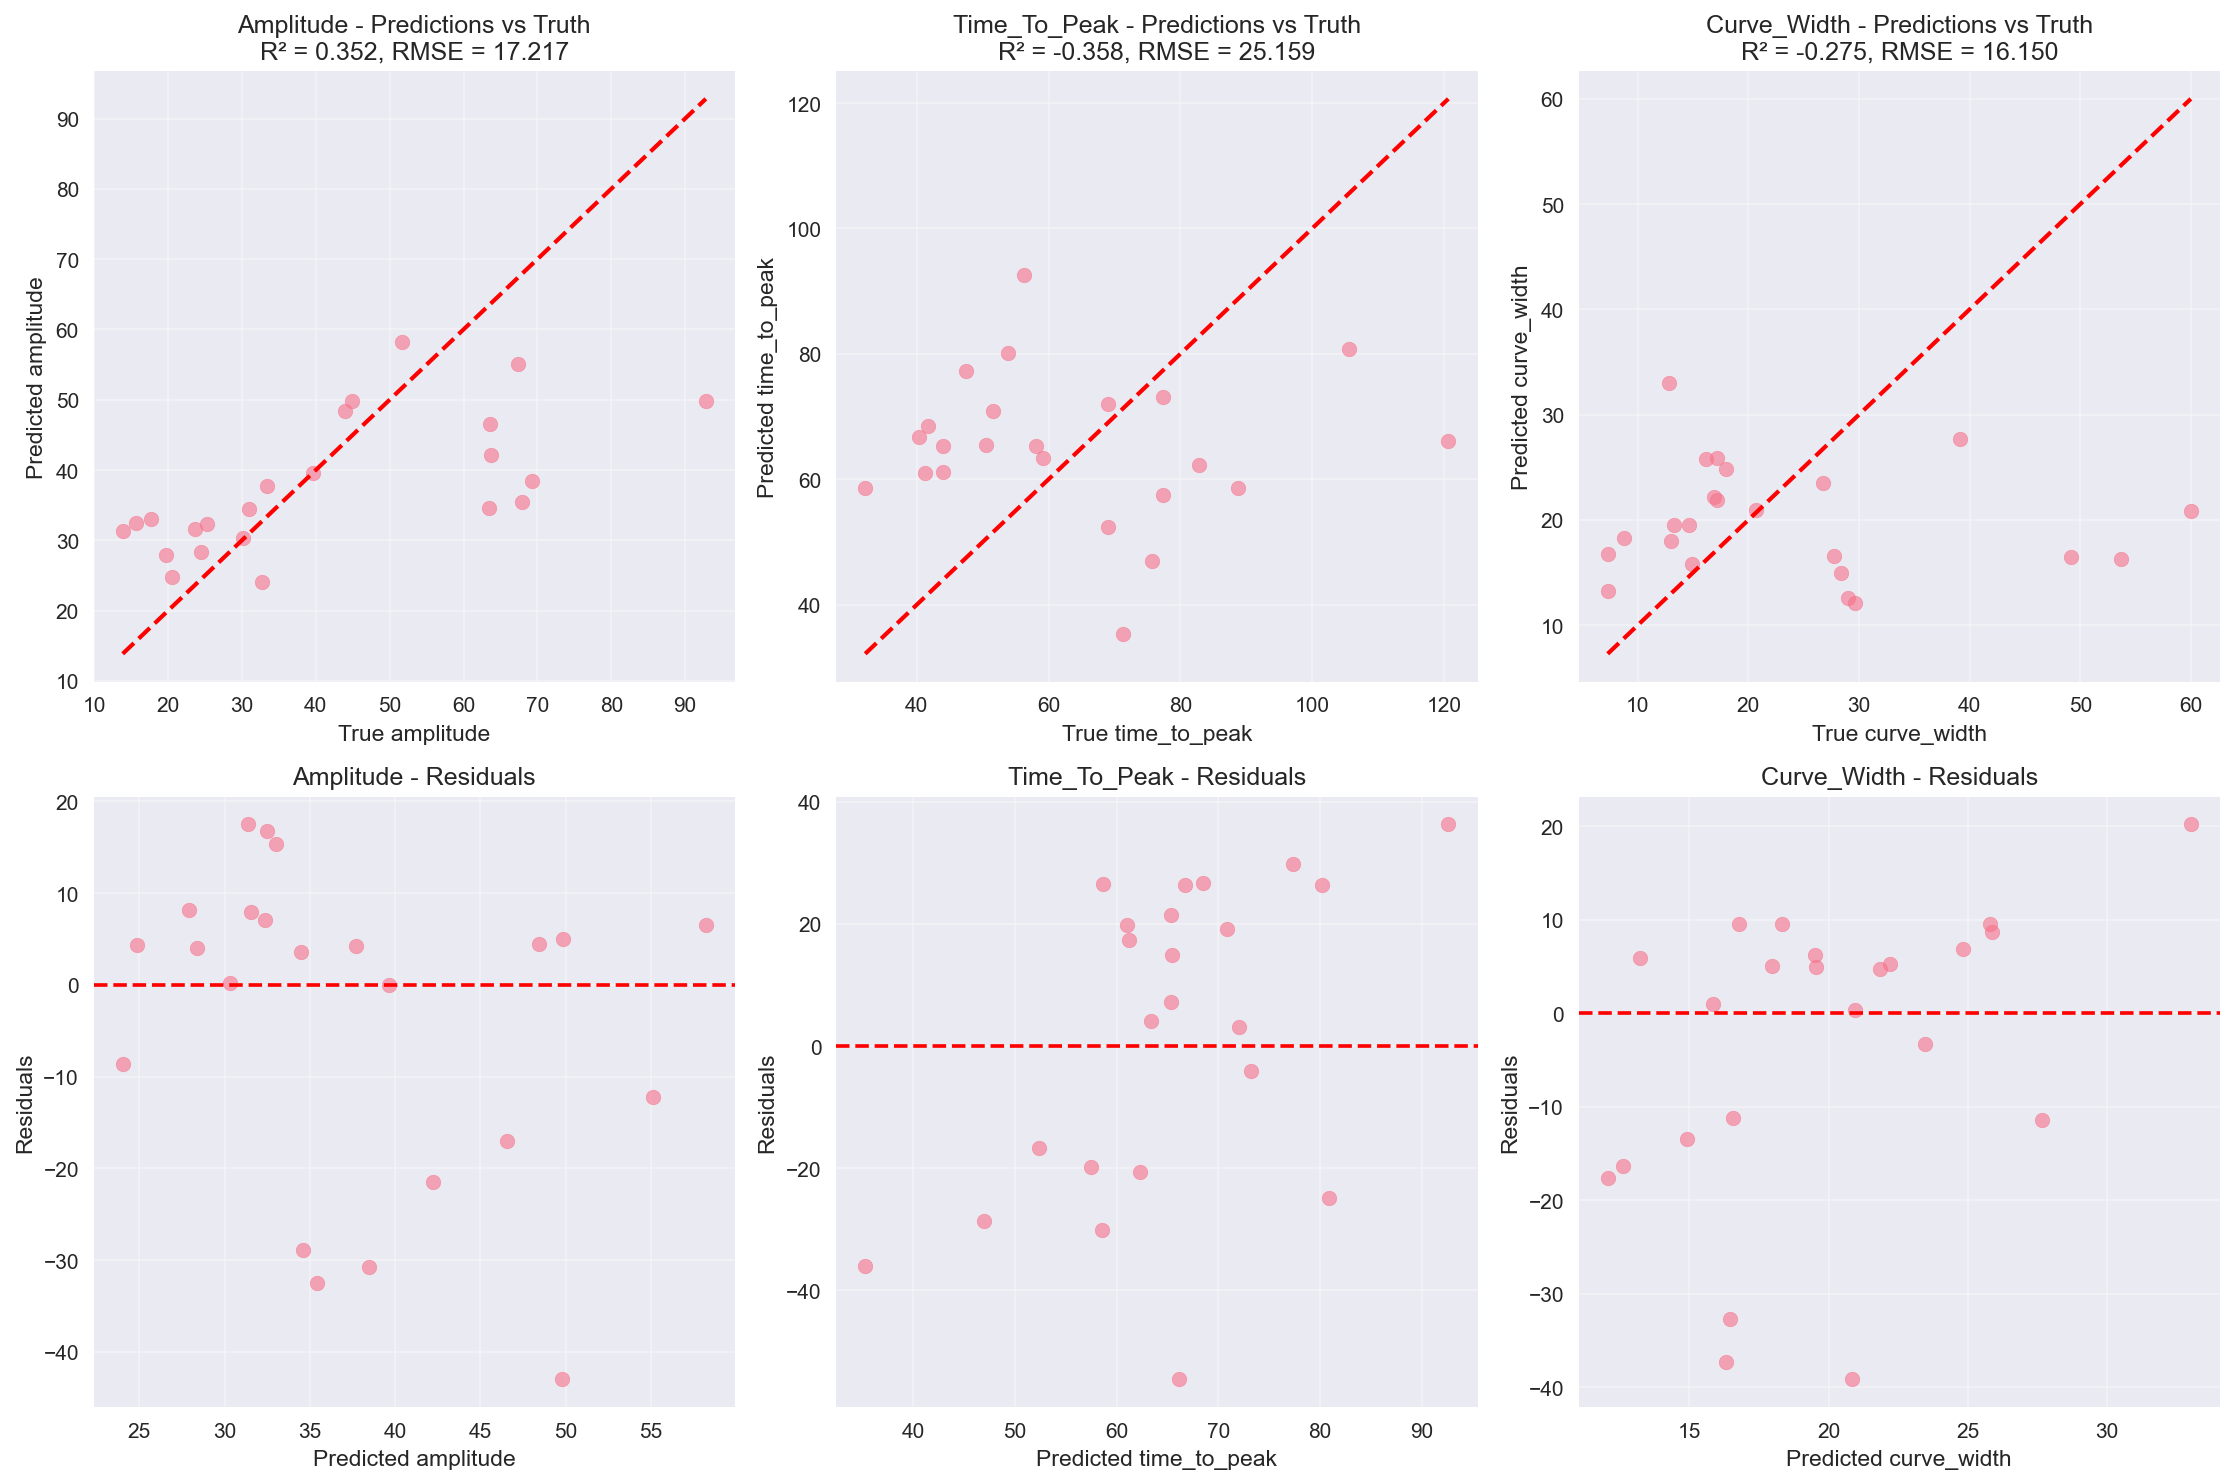

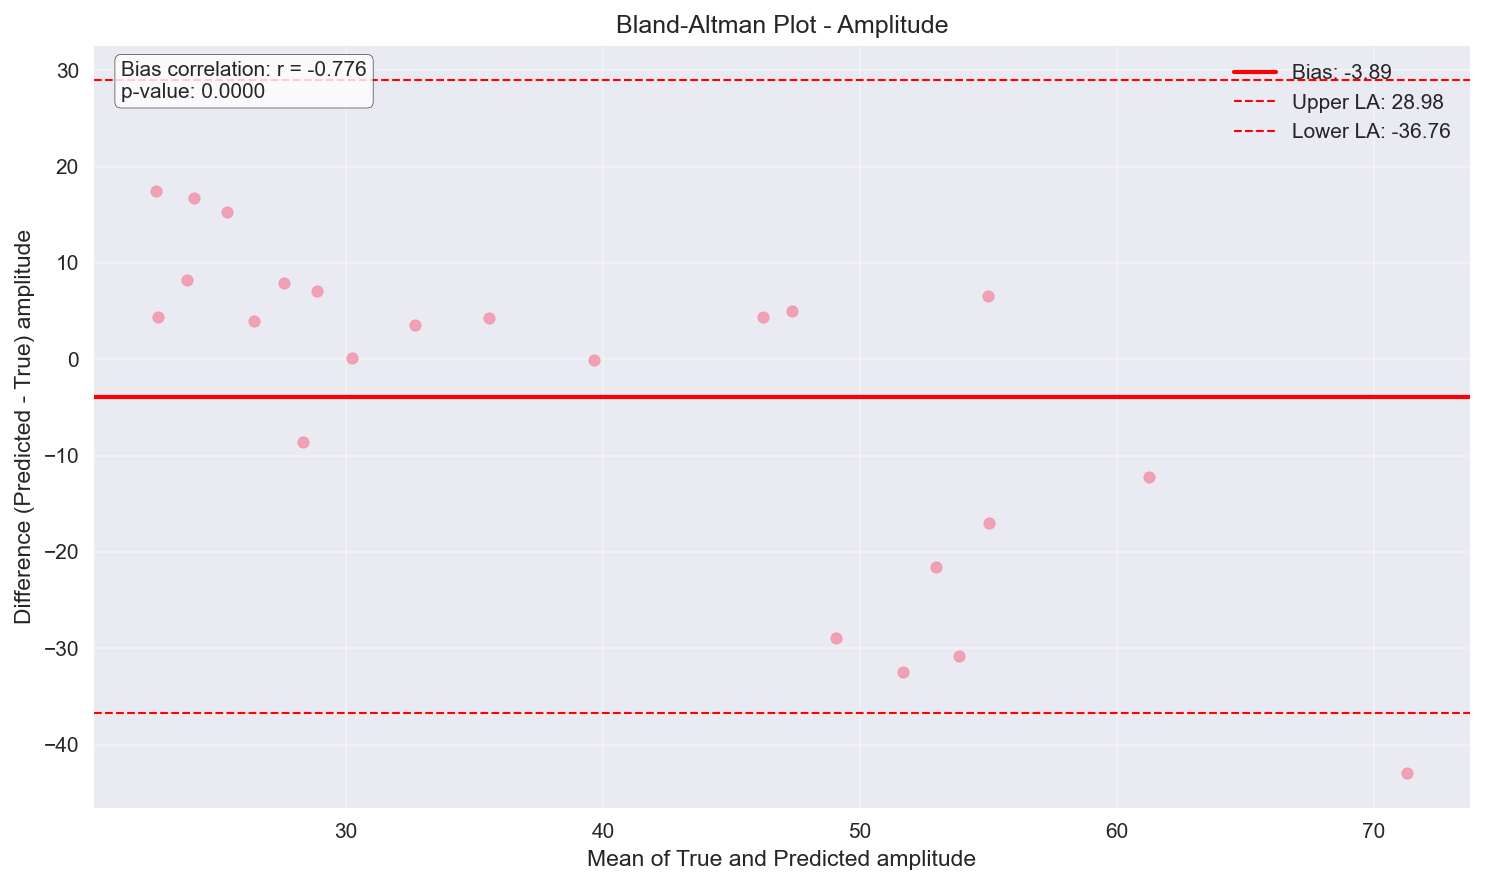

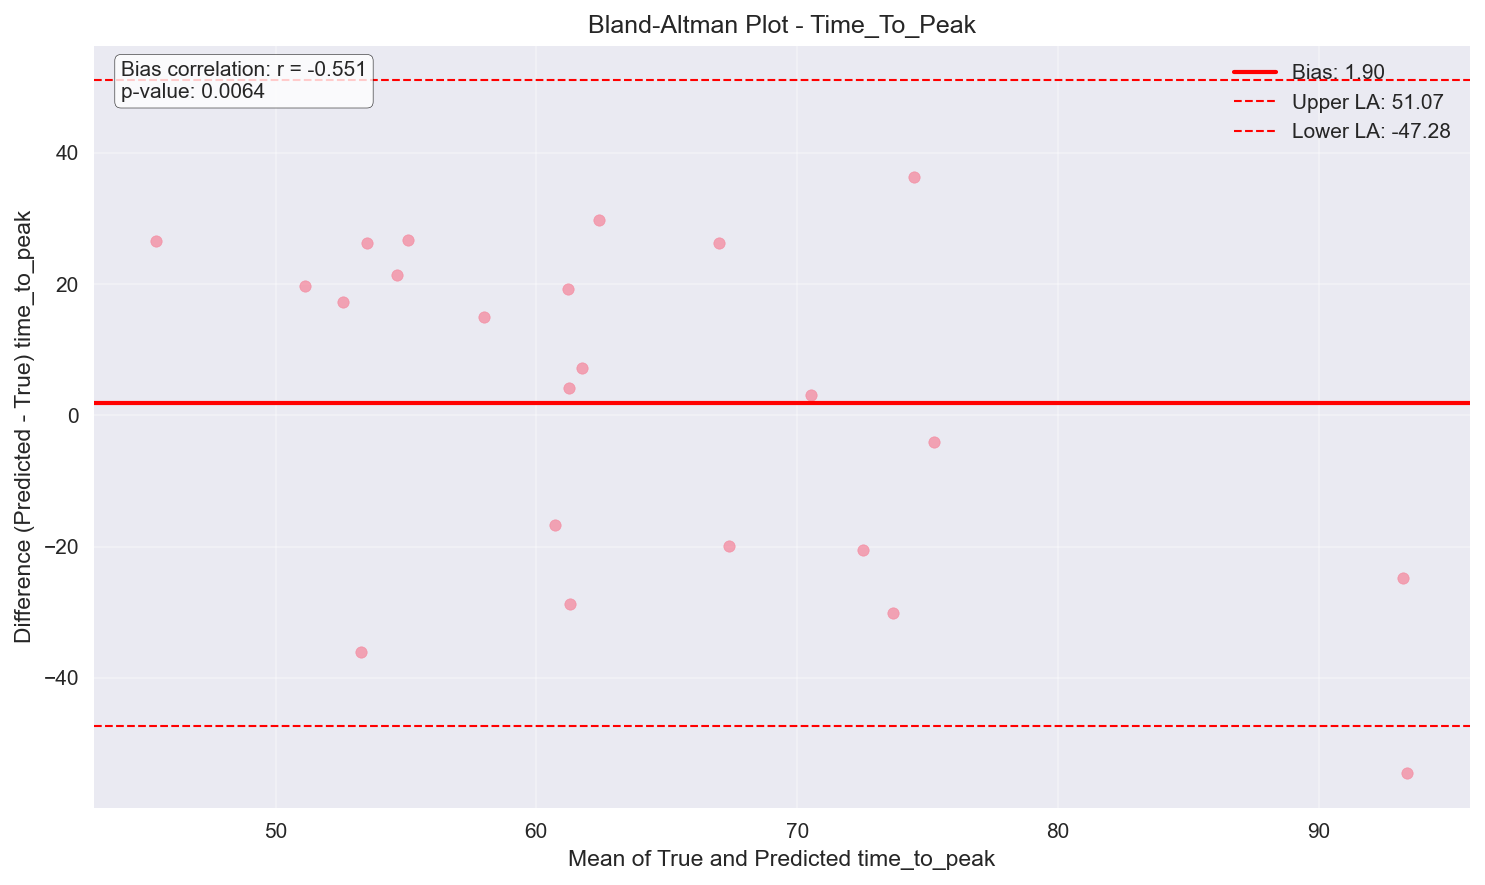

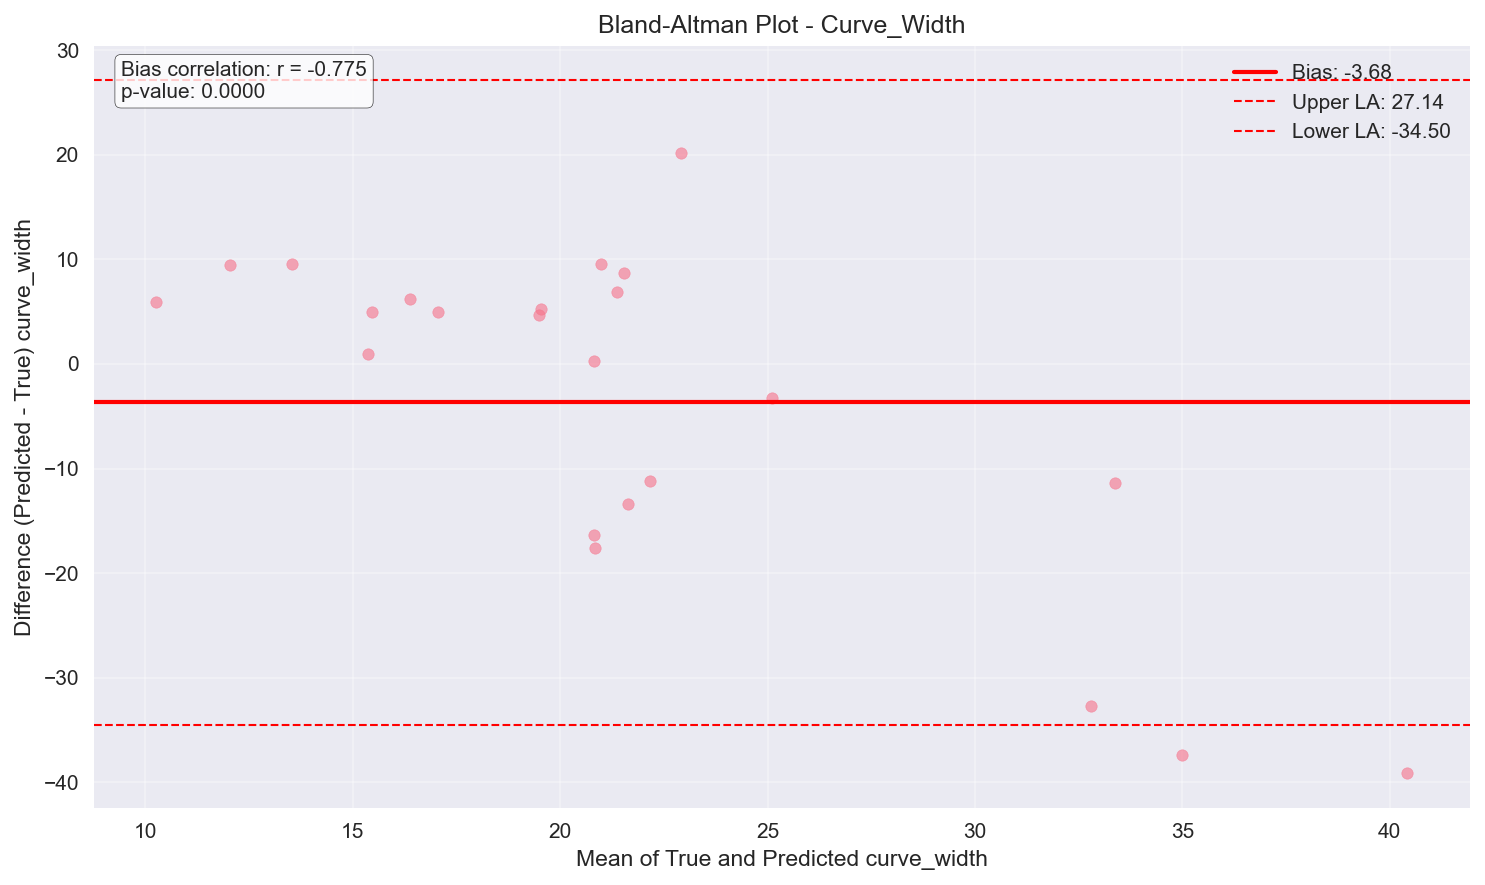

In [10]:
plotter = GlucosePlotter()

# Plot model performance
plotter.plot_model_performance(model_results)

# Bland-Altman plots
for target_name in model_results.keys():
    bland_altman_data = xgboost_regressor.create_bland_altman_analysis(target_name)
    plotter.plot_bland_altman(bland_altman_data, target_name)

## Multi-linear Regression Model

In [12]:
mlr = MultiLinearRegressor()
mlr_results = mlr.train(df_ml)

print("\nMulti-linear Regression Results:")
print(f"R²: {mlr_results['r2']:.3f}")
print(f"RSE: {mlr_results['rse']:.2f} mg/dL")

High correlation detected: [('PRO', 'CHO_PRO'), ('FAT', 'CHO_FAT')]
Removing features: ['CHO_FAT', 'PRO']
High condition number (4.00e+16), using Ridge regression



Multi-linear Regression Results:
R²: 0.237
RSE: 17.78 mg/dL


## Feature Importance (SHAP Analysis)


Calculating SHAP values for amplitude...

Calculating SHAP values for time_to_peak...

Calculating SHAP values for curve_width...


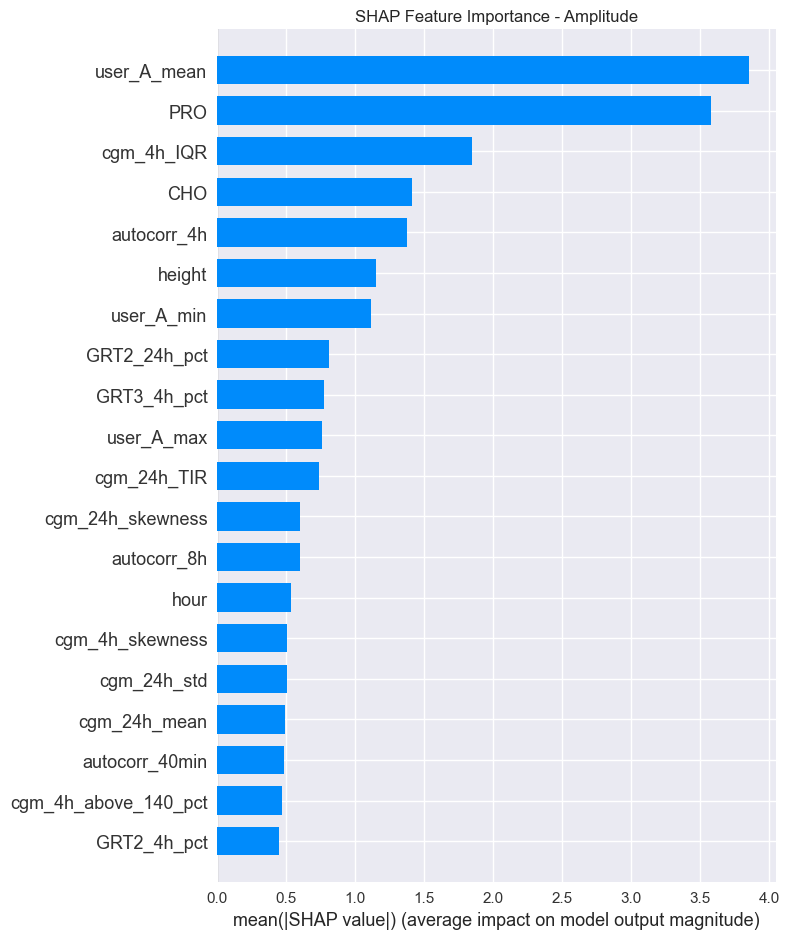

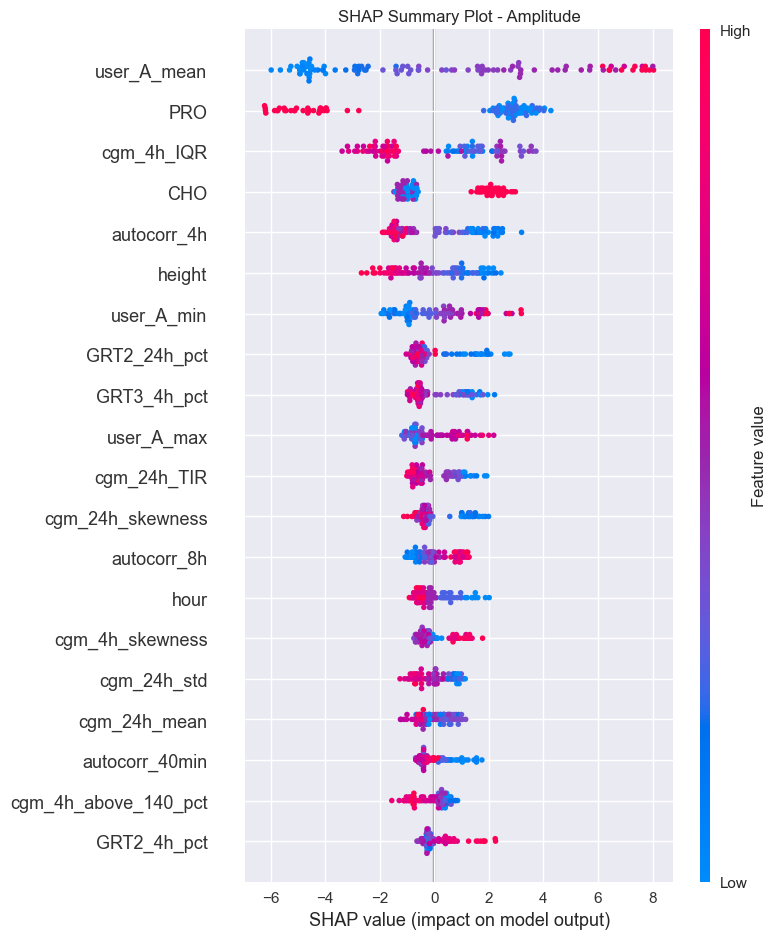

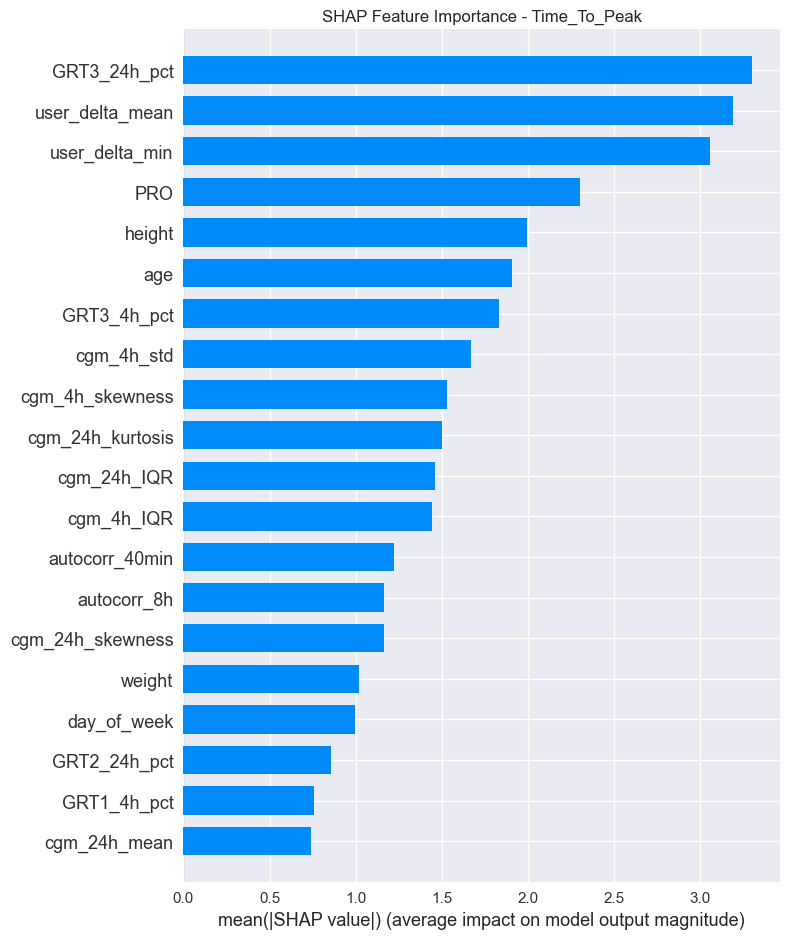

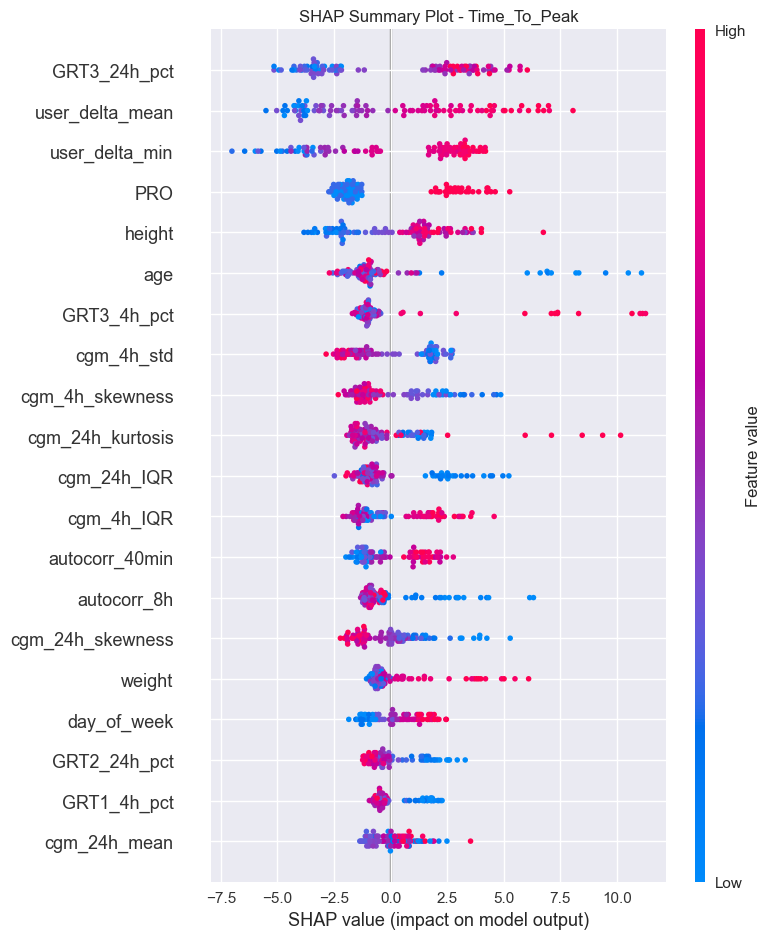

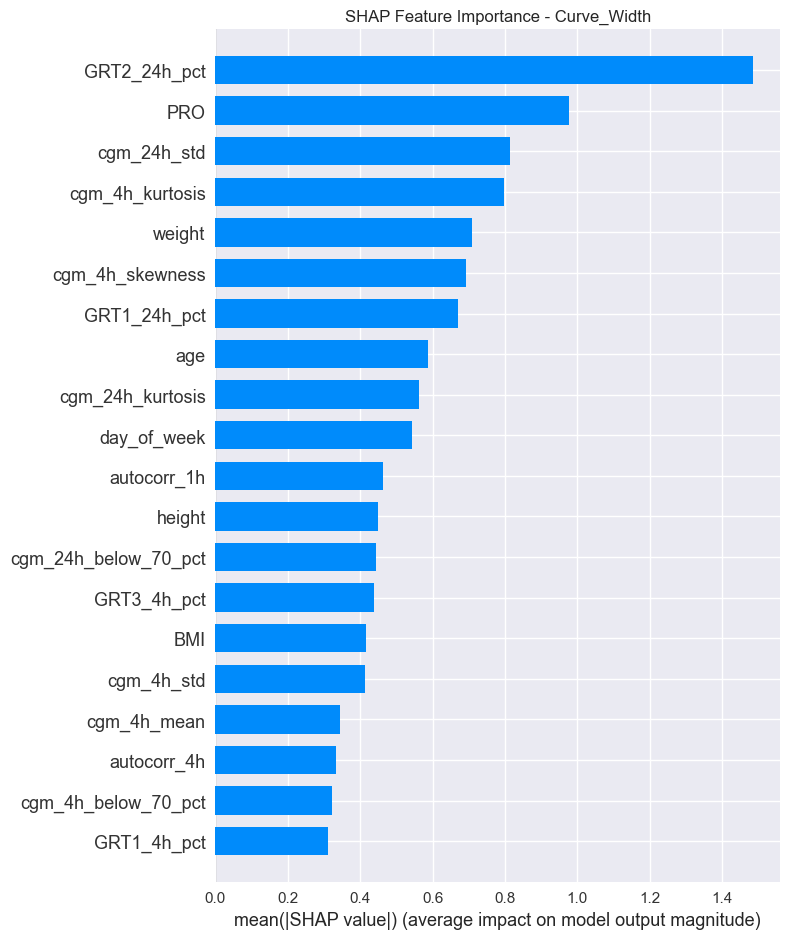

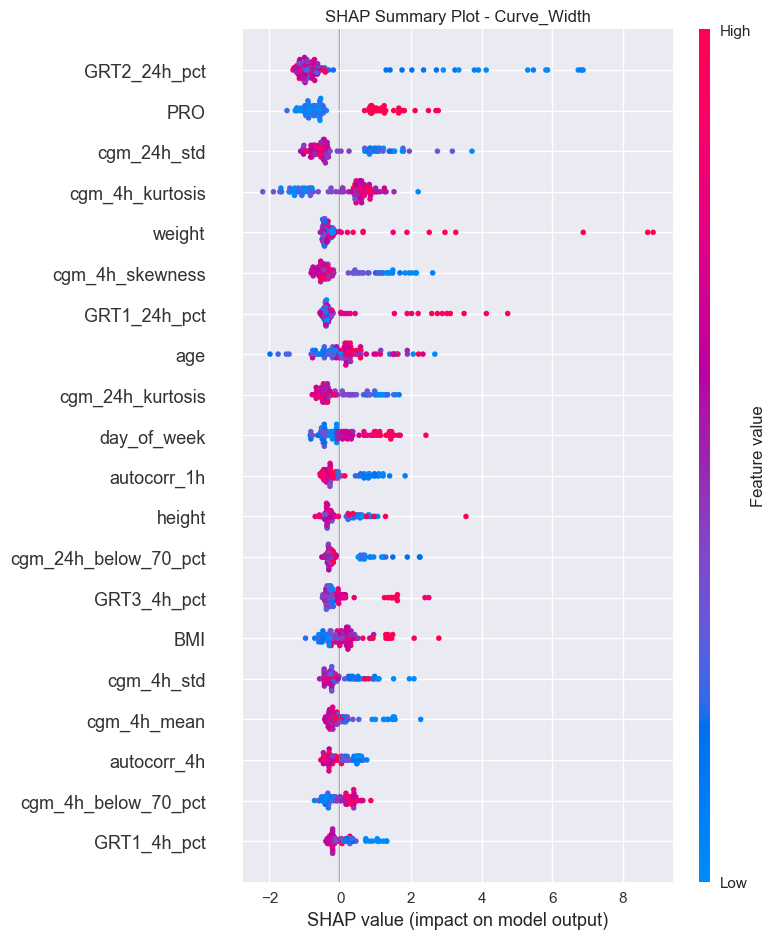

In [13]:
if len(df_ml) > 50:  # Only if we have enough samples
    for target_name in model_results.keys():
        print(f"\nCalculating SHAP values for {target_name}...")
        
        # Sample data for SHAP analysis (computationally expensive)
        X_sample = df_ml.sample(min(100, len(df_ml)))
        X_features, _ = xgboost_regressor.prepare_features(X_sample)
        
        shap_values = xgboost_regressor.calculate_shap_values(X_features, target_name)
        plotter.plot_shap_values(shap_values, X_features, target_name)

## Generate Comprehensive Report

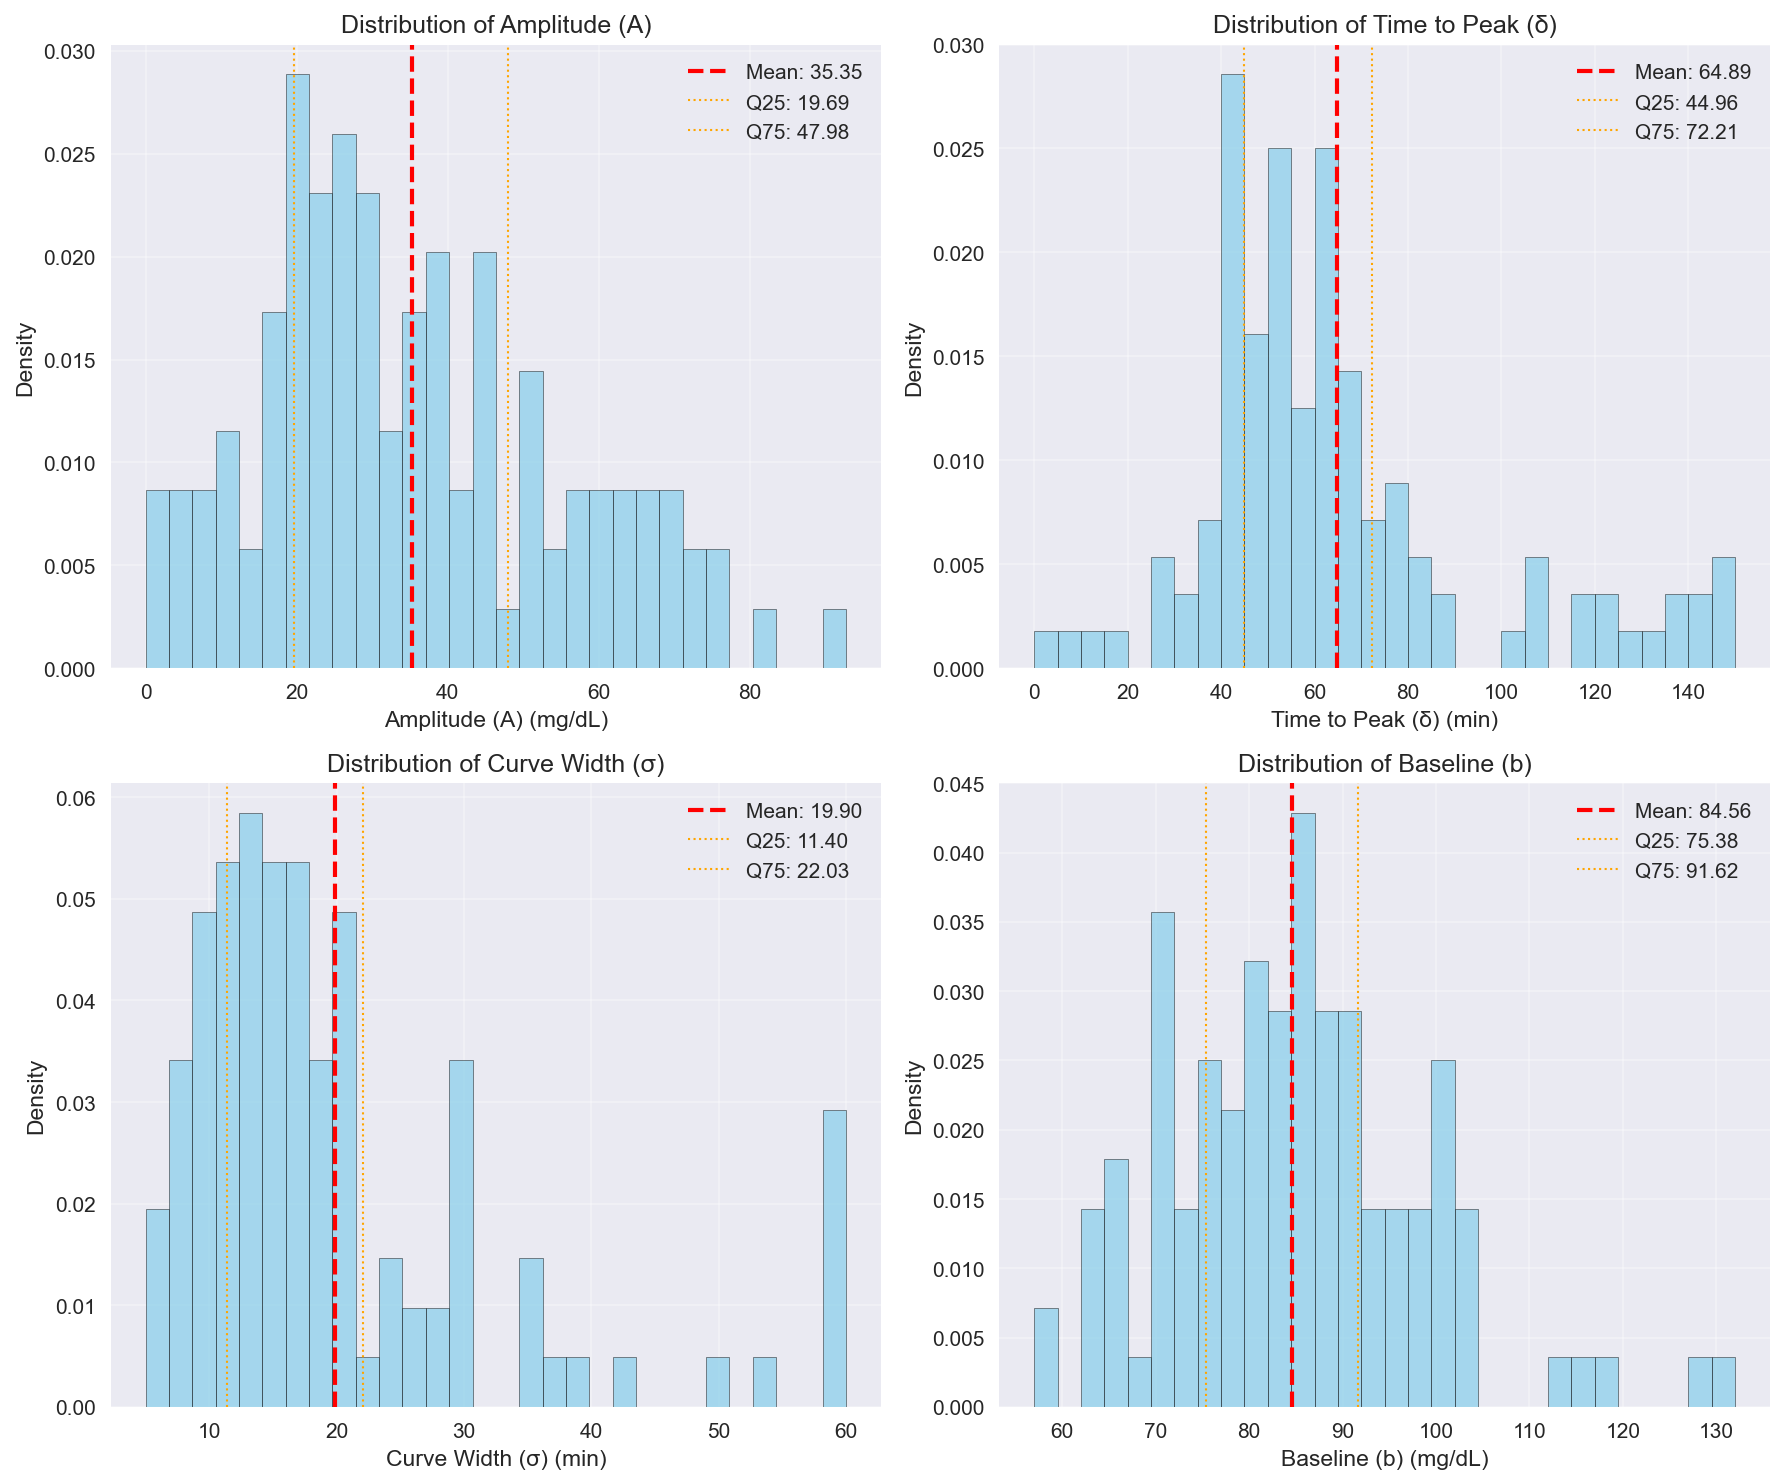

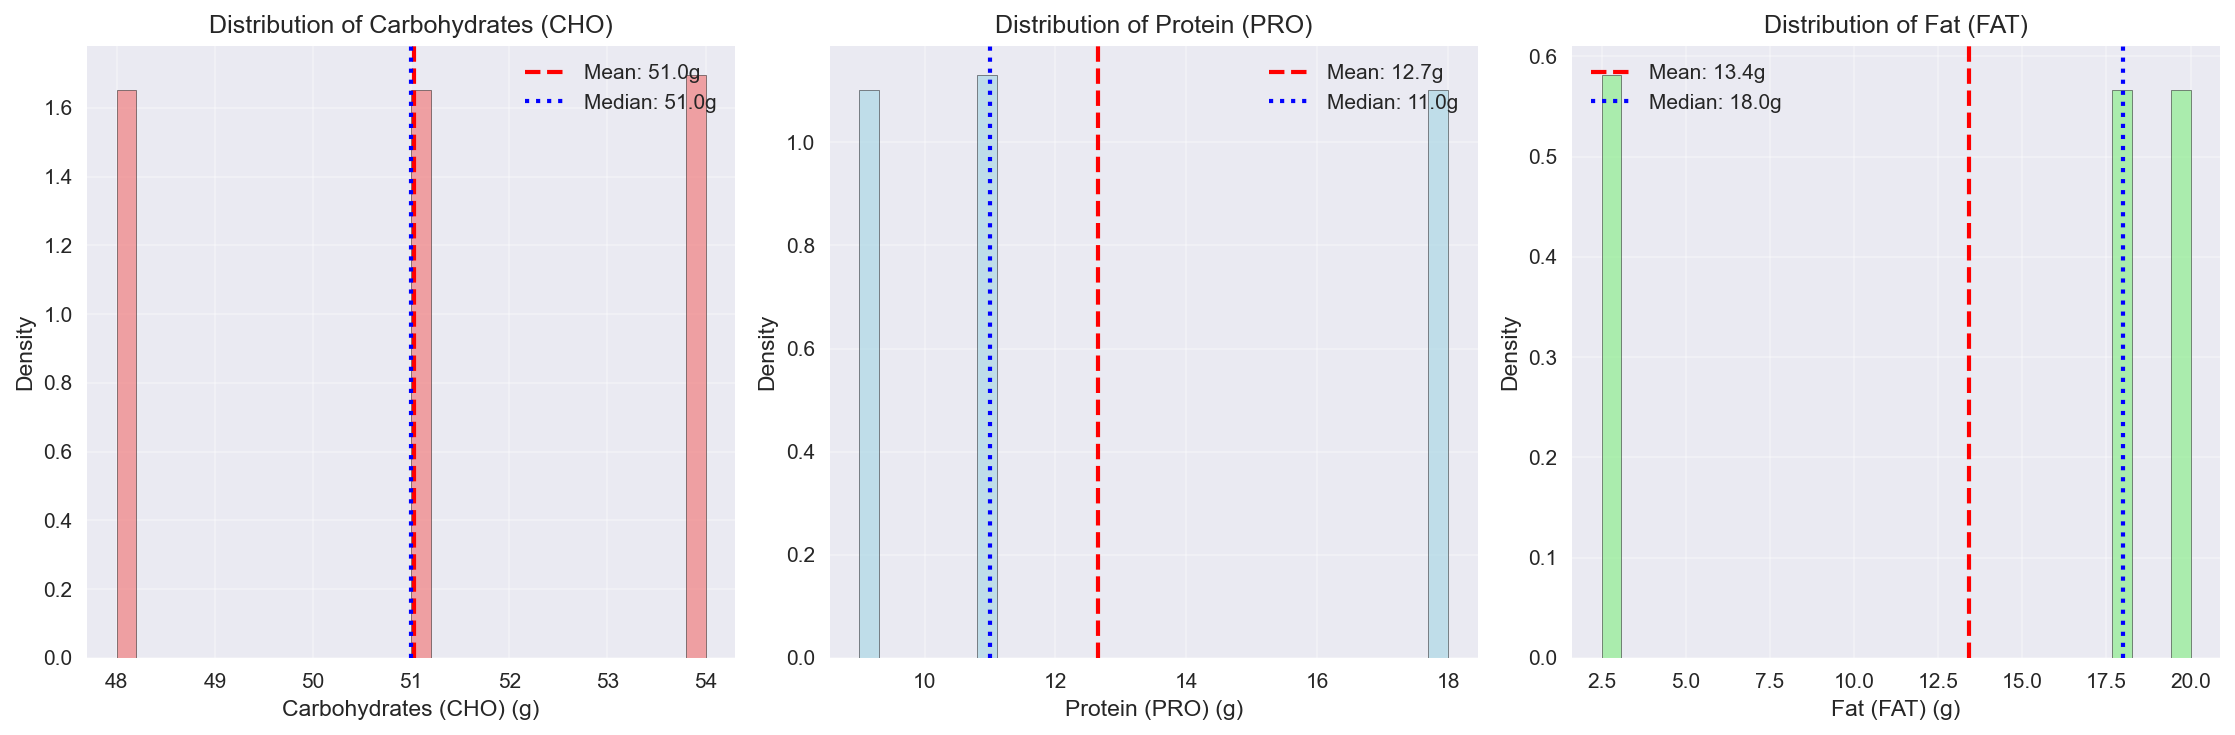

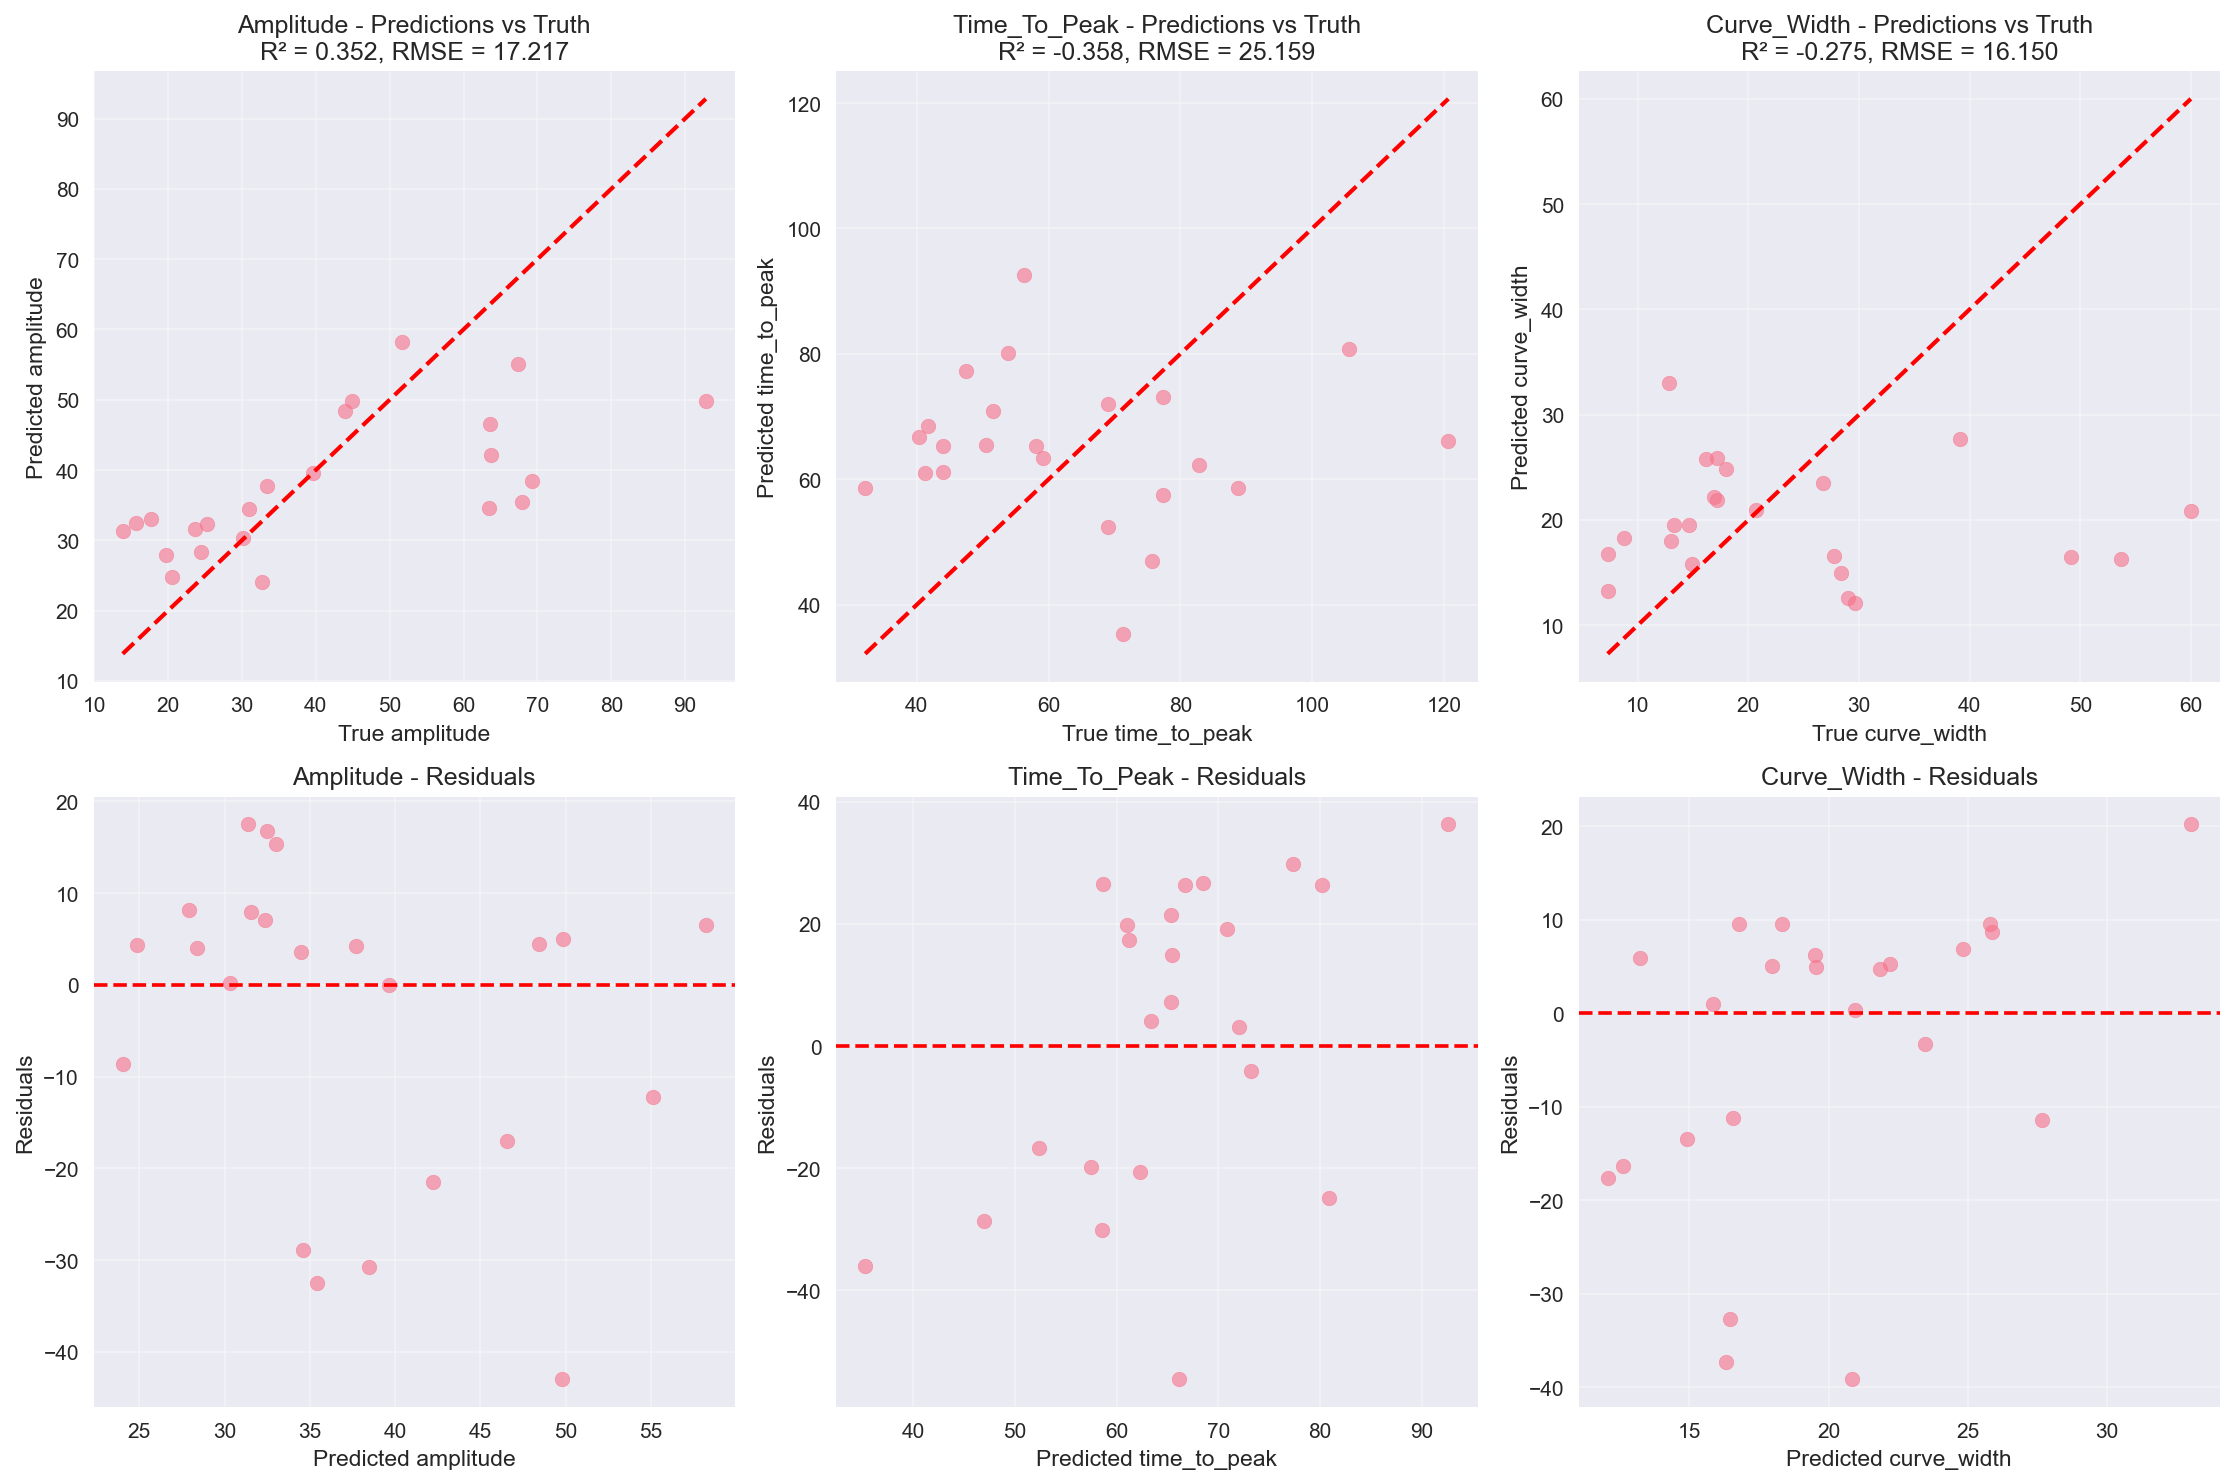

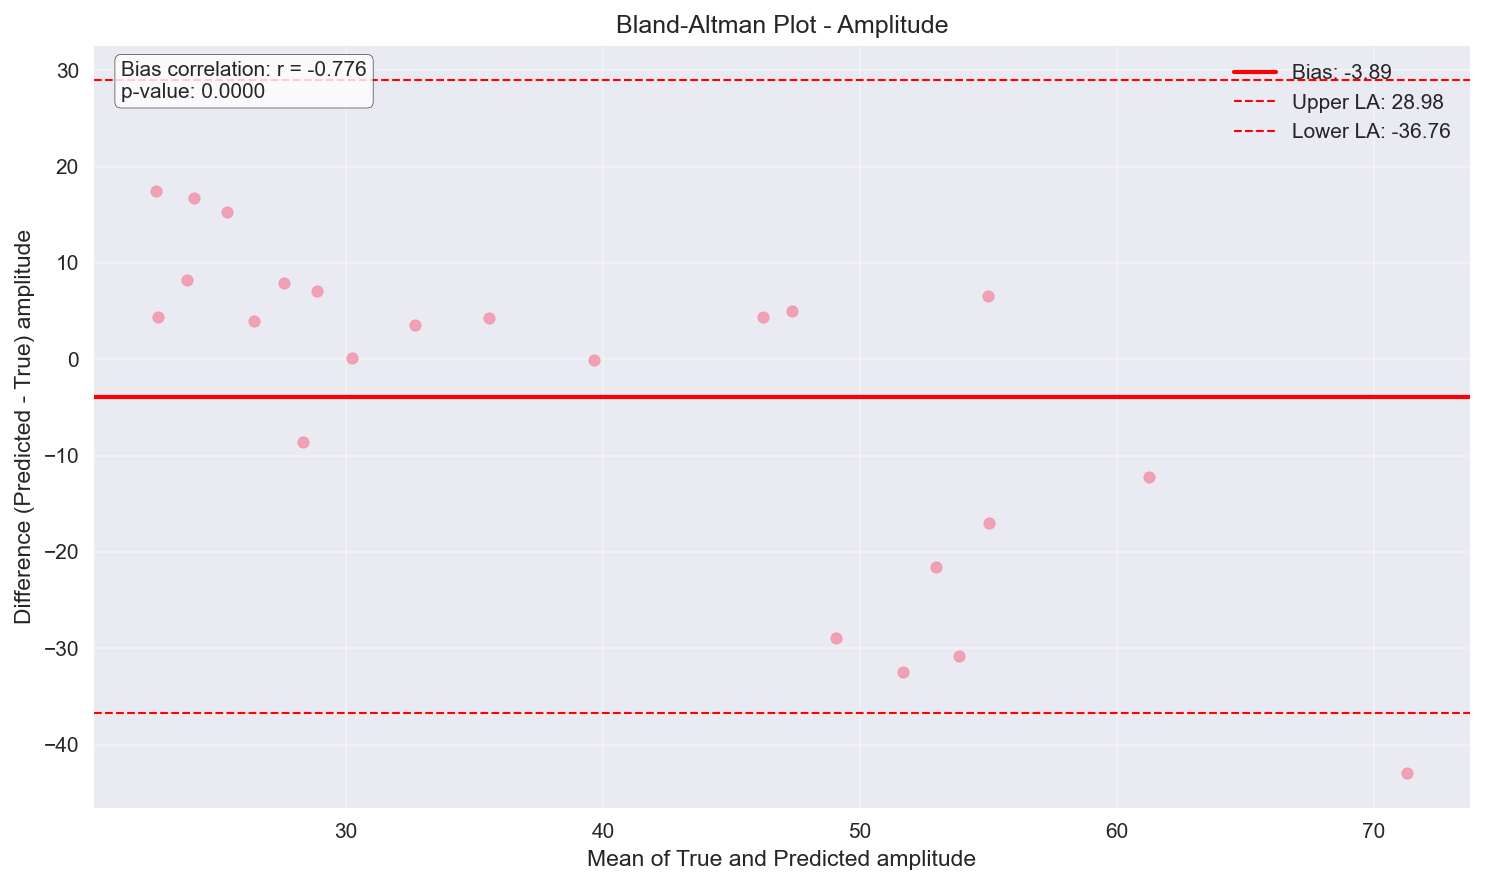

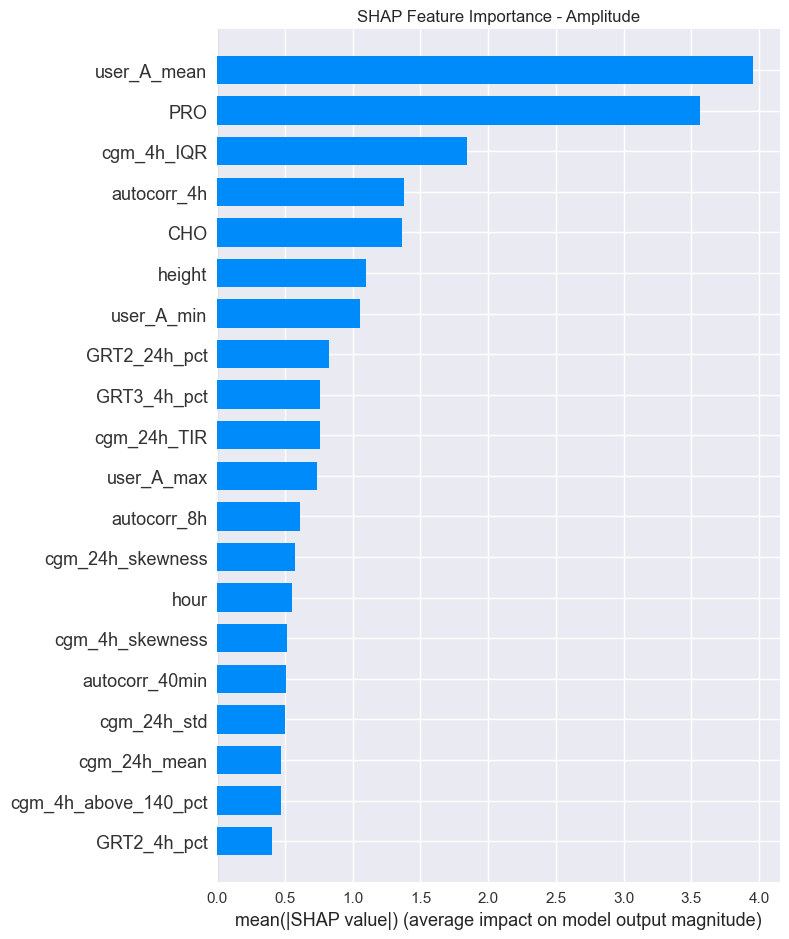

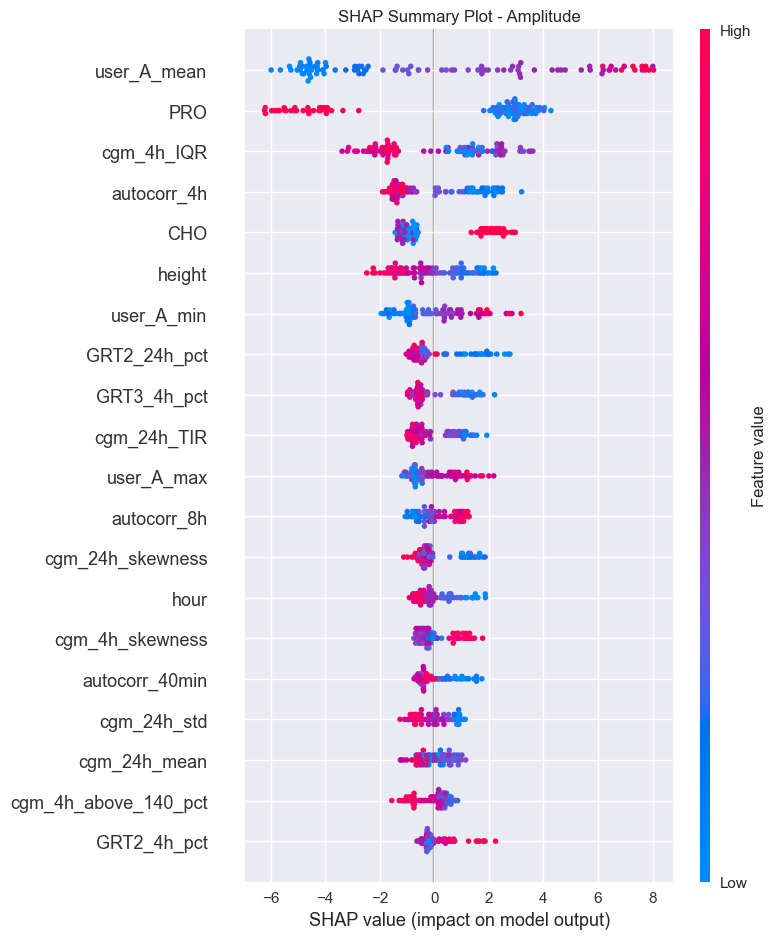

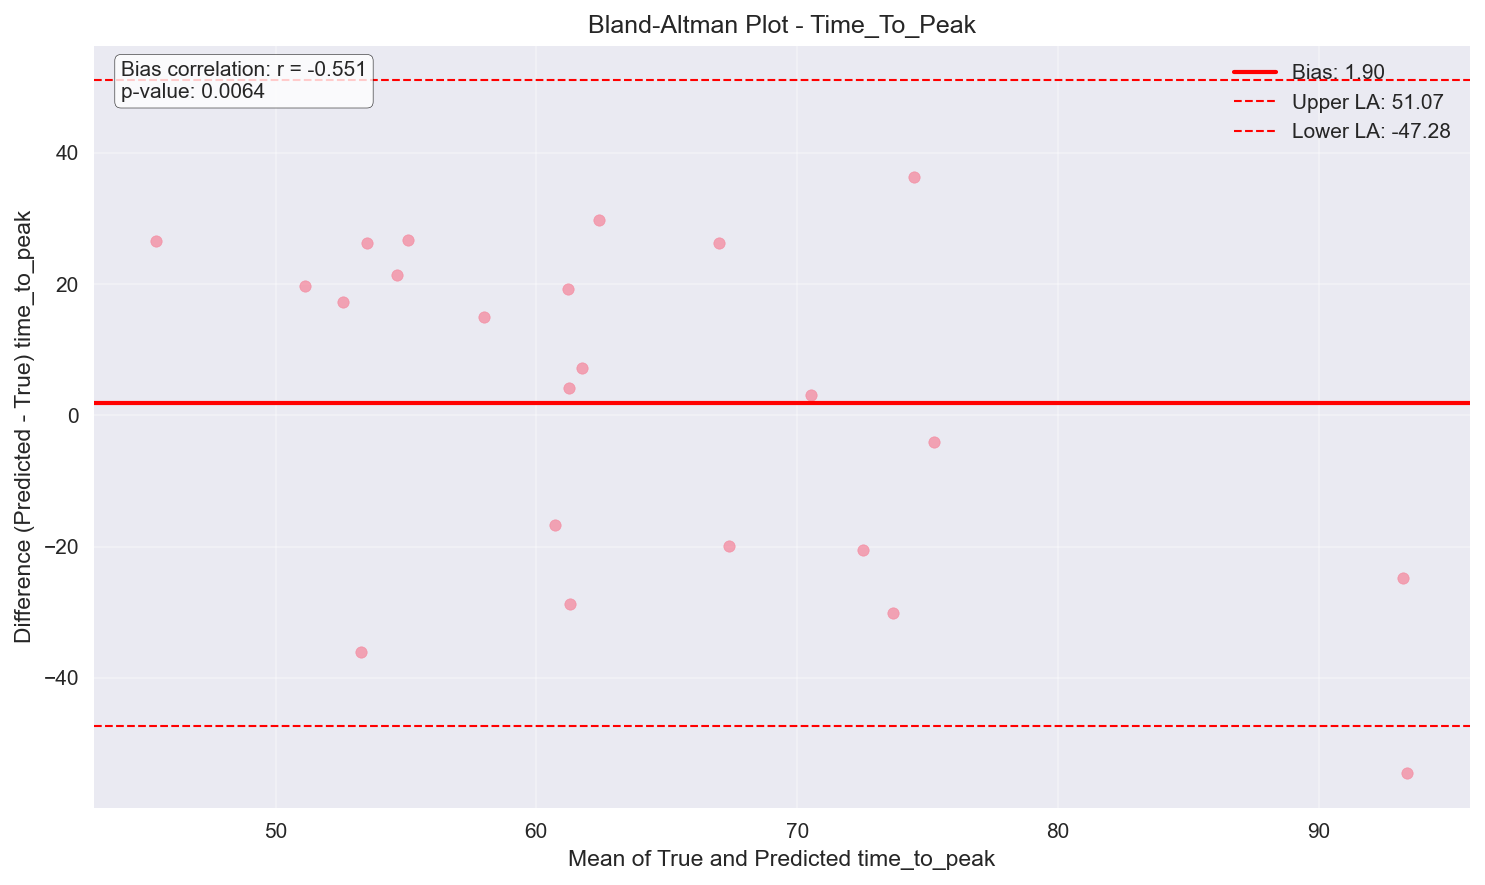

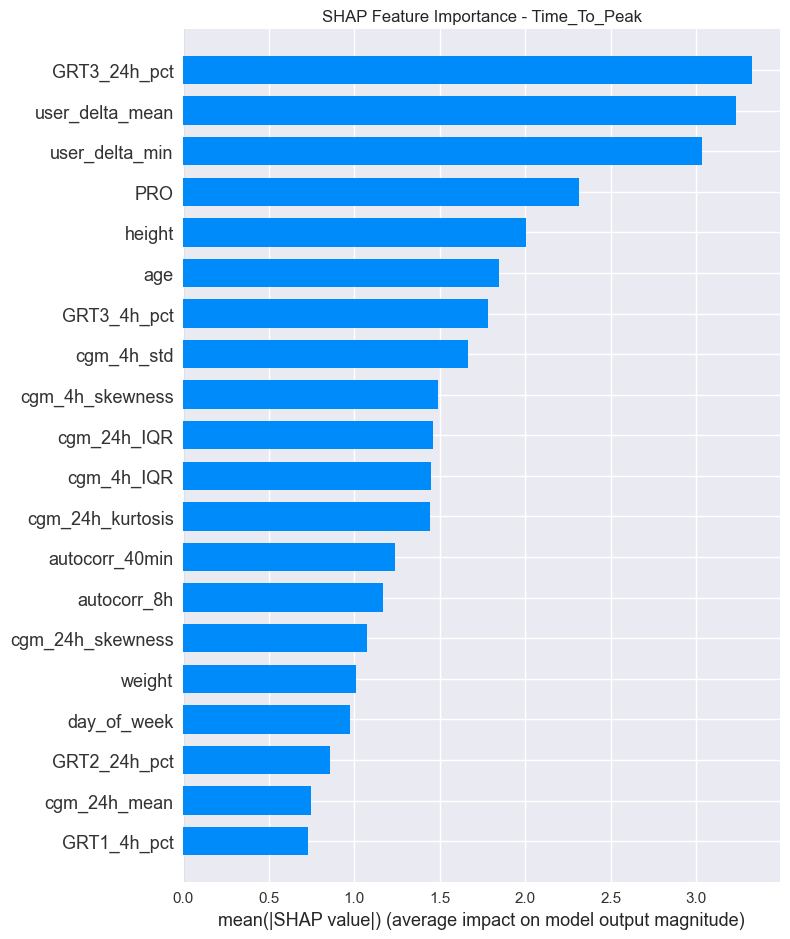

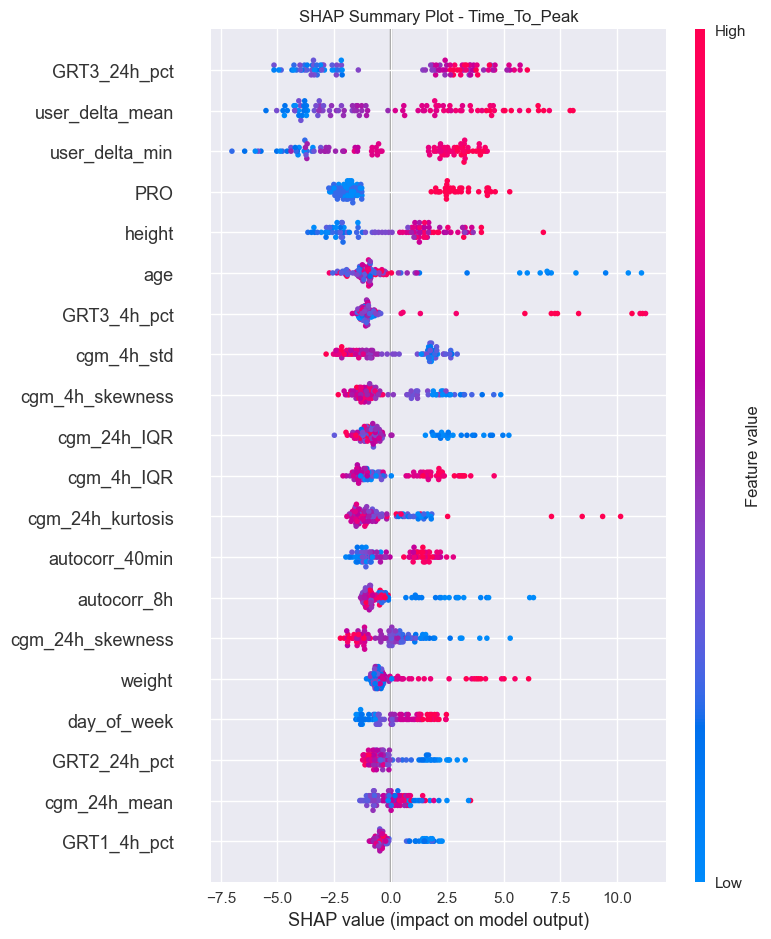

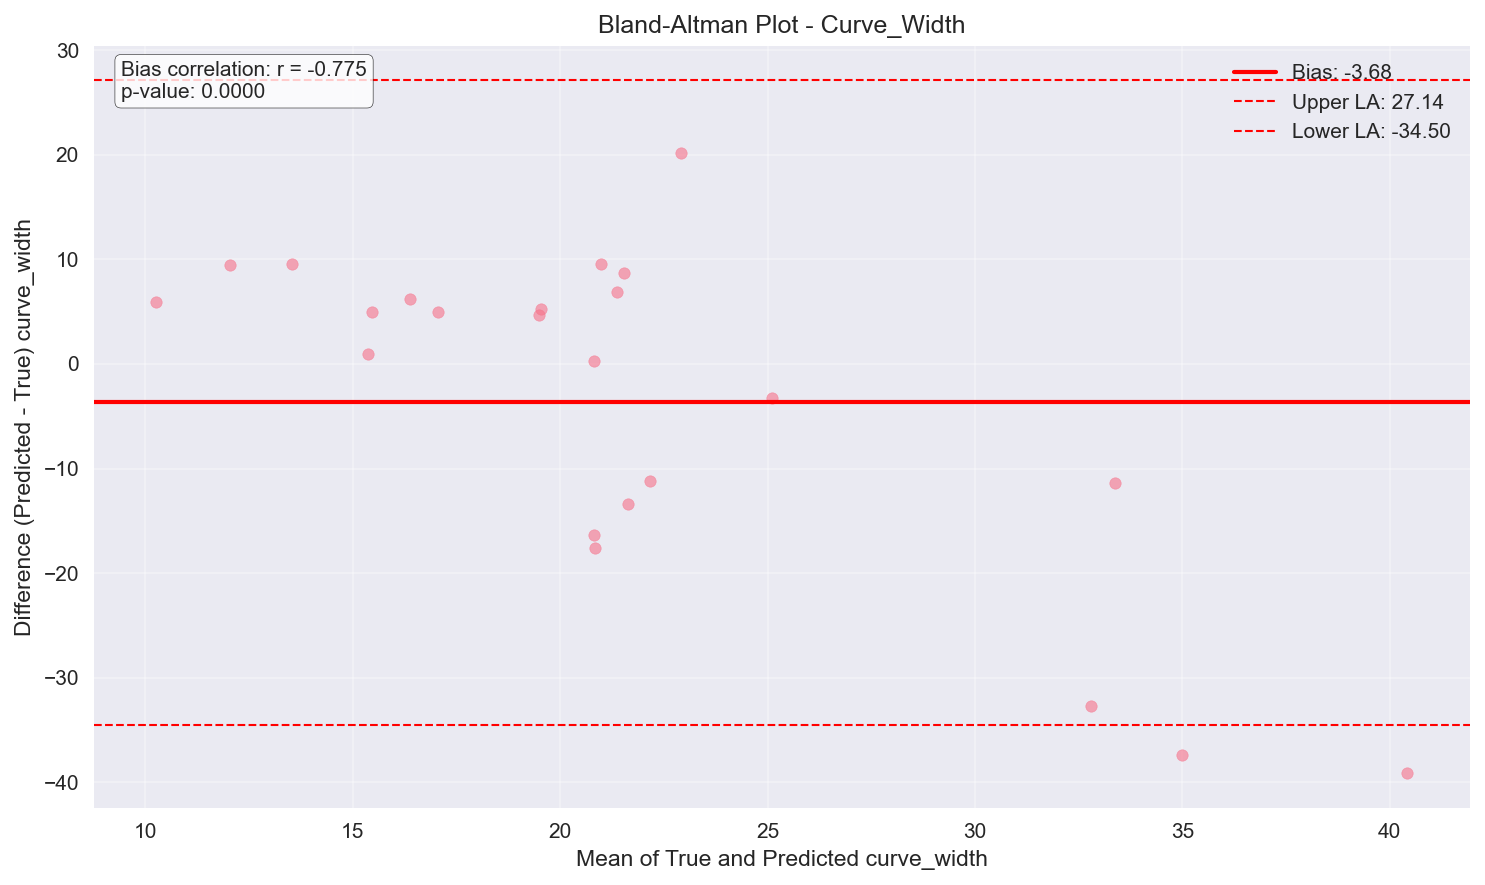

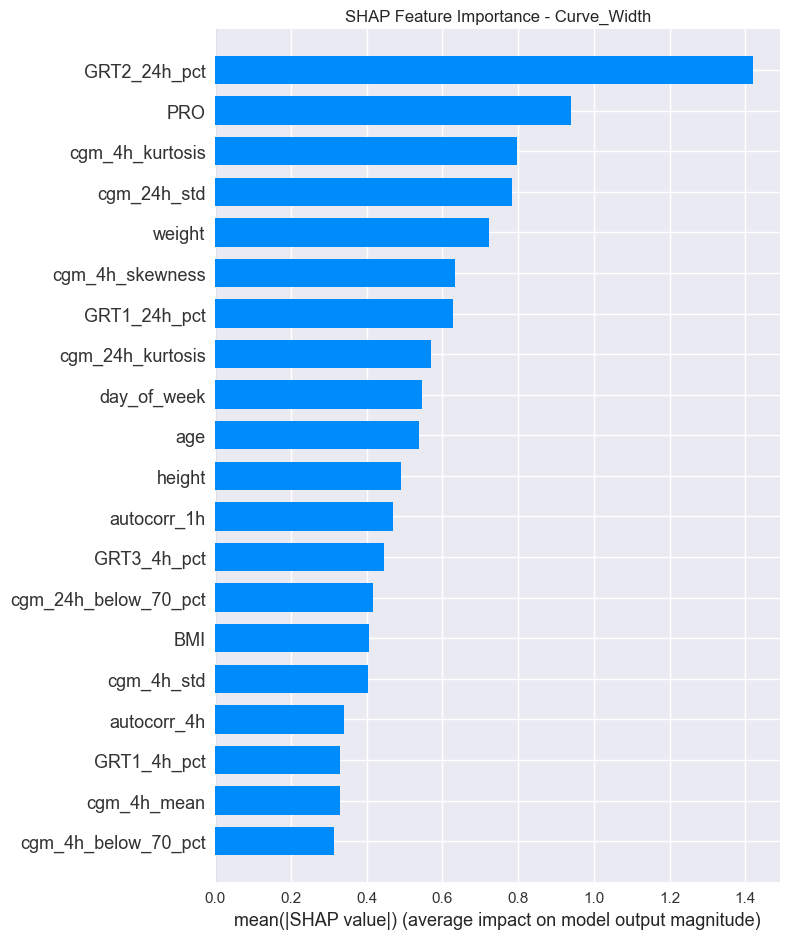

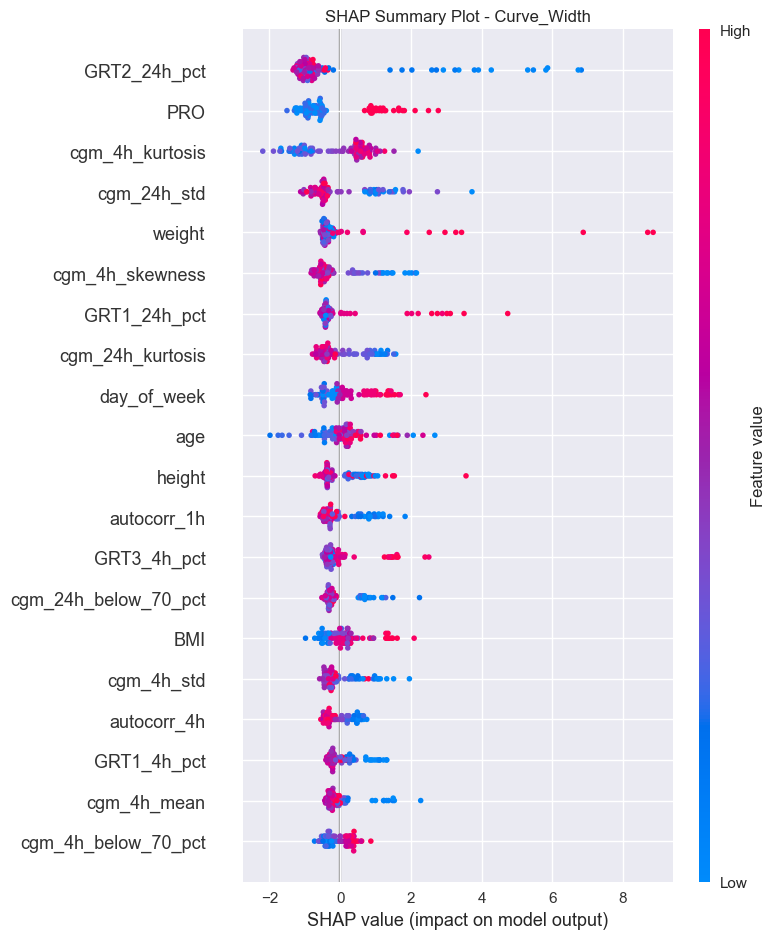

In [14]:
plotter.create_comprehensive_report(df_fitted_params, model_results, df_ml, xgboost_regressor)

## Save Results

In [15]:
results_path = Path('../results')
results_path.mkdir(exist_ok=True)

# Save datasets
df_fitted_params.to_csv(results_path / 'fitted_parameters.csv', index=False)
df_ml.to_csv(results_path / 'ml_dataset.csv', index=False)

# Save models
xgboost_regressor.save_models(results_path / 'models')

print(f"\nResults saved to {results_path}")


Results saved to ../results
